# Northwind traders Project
In this project we will be analyzing which is an international gourmet food distributor. We will be looking at the Northwind database to do the following:


*   Evaluate employee performance to boost productivity
*   Optimzing inventory and marketing strategies by analyzing product sales


*   Looking at the sales growth to see any trends and make forecasts based on the company progress
*   See client behavior to single out high value clients and offer promotions


All of this will help the company make better decisions for better growth and progression.





In [ ]:
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt
import numpy as np

conn = sqlite3.connect("northwind.db")

In [ ]:
# lets combine tables in the database to examine the results closer
q1 = '''
SELECT e.Firstname||' '||e.Lastname AS employee_name, o.OrderID, o.OrderDate
FROM Employees e
JOIN orders o ON e.EmployeeID=o.EmployeeID
LIMIT 10
'''
results1 = pd.read_sql(q1, conn)
results1.head()


,employee_name,OrderID,OrderDate
0,Steven Buchanan,10248,2016-07-04
1,Michael Suyama,10249,2016-07-05
2,Margaret Peacock,10250,2016-07-08
3,Janet Leverling,10251,2016-07-08
4,Margaret Peacock,10252,2016-07-09


In [ ]:
q2 = '''
SELECT pr.ProductName, od.Quantity, o.OrderID
FROM Products pr
JOIN `Order Details` od ON pr.ProductID=od.ProductID
JOIN Orders o ON o.OrderID=od.OrderID
LIMIT 10
'''
results2 = pd.read_sql(q2, conn)
results2.head()


,ProductName,Quantity,OrderID
0,Queso Cabrales,12,10248
1,Singaporean Hokkien Fried Mee,10,10248
2,Mozzarella di Giovanni,5,10248
3,Tofu,9,10249
4,Manjimup Dried Apples,40,10249


In [ ]:
q3 = '''
SELECT c.ContactName, o.OrderID, o.OrderDate
FROM Customers c
JOIN Orders o ON c.CustomerID=o.CustomerID
LIMIT 10
'''
results3 = pd.read_sql(q3, conn)
results3.head()

,ContactName,OrderID,OrderDate
0,Paul Henriot,10248,2016-07-04
1,Karin Josephs,10249,2016-07-05
2,Mario Pontes,10250,2016-07-08
3,Mary Saveley,10251,2016-07-08
4,Pascale Cartrain,10252,2016-07-09


In [ ]:
# lets rank the employees using a CTE to find which employees performed the best on total sales

q4 = '''
WITH employee_sales AS (
SELECT e.Firstname||' '||e.Lastname AS employee_name, e.EmployeeID, SUM(od.Quantity*od.UnitPrice*(1-od.Discount)) AS total_sales
FROM Orders o
JOIN `Order Details` od ON o.OrderID=od.OrderID
JOIN Employees e ON o.EmployeeID=e.EmployeeID
GROUP BY e.EmployeeID
)
SELECT employee_name, RANK() OVER (ORDER BY total_sales DESC) AS sales_rank
FROM employee_sales;
'''
results4 = pd.read_sql(q4, conn)
results4.head()

,employee_name,sales_rank
0,Margaret Peacock,1
1,Steven Buchanan,2
2,Janet Leverling,3
3,Nancy Davolio,4
4,Robert King,5


In [ ]:
# running total sales
q5 = ''' WITH monthly_sales AS (
SELECT SUM(od.Quantity*od.UnitPrice*(1-od.Discount)) AS total_sales, STRFTIME('%Y-%m', o.OrderDate) AS month
FROM Orders o
JOIN `Order Details` od ON o.OrderID=od.OrderID
GROUP BY STRFTIME('%Y-%m', o.OrderDate)
)
SELECT month, SUM(total_sales) OVER (ORDER BY month) AS cumulative_sales
FROM monthly_sales
ORDER BY month;
'''
results5 = pd.read_sql(q5, conn)
results5

,month,cumulative_sales
0,2012-07,2.066219e+06
1,2012-08,5.623095e+06
2,2012-09,9.063240e+06
3,2012-10,1.226477e+07
4,2012-11,1.524526e+07
...,...,...
131,2023-06,4.352751e+08
132,2023-07,4.386254e+08
133,2023-08,4.419186e+08
134,2023-09,4.454633e+08


In [ ]:
# sales and growth rates
q6 = ''' WITH monthlysales AS (
  SELECT SUM(od.Quantity*od.UnitPrice*(1-od.Discount)) AS total_sales, STRFTIME('%Y-%m', o.OrderDate) AS date
  FROM Orders o
  JOIN `Order Details` od ON o.OrderID=od.OrderID
  GROUP BY STRFTIME('%Y-%m', o.OrderDate)
),
previous_month AS (
  SELECT date, total_sales, LAG(total_sales) OVER (ORDER BY date) AS previous_sales
  FROM monthlysales
)
SELECT date, total_sales, previous_sales, ROUND(((total_sales - previous_sales) / previous_sales)*100,2) AS growth_rate
FROM previous_month;
'''
results6 = pd.read_sql(q6, conn)
results6


,date,total_sales,previous_sales,growth_rate
0,2012-07,2066219.40,NaN,NaN
1,2012-08,3556875.79,2066219.40,72.14
2,2012-09,3440144.98,3556875.79,-3.28
3,2012-10,3201529.96,3440144.98,-6.94
4,2012-11,2980494.74,3201529.96,-6.90
...,...,...,...,...
131,2023-06,3071787.73,3896544.35,-21.17
132,2023-07,3350337.36,3071787.73,9.07
133,2023-08,3293158.67,3350337.36,-1.71
134,2023-09,3544698.51,3293158.67,7.64


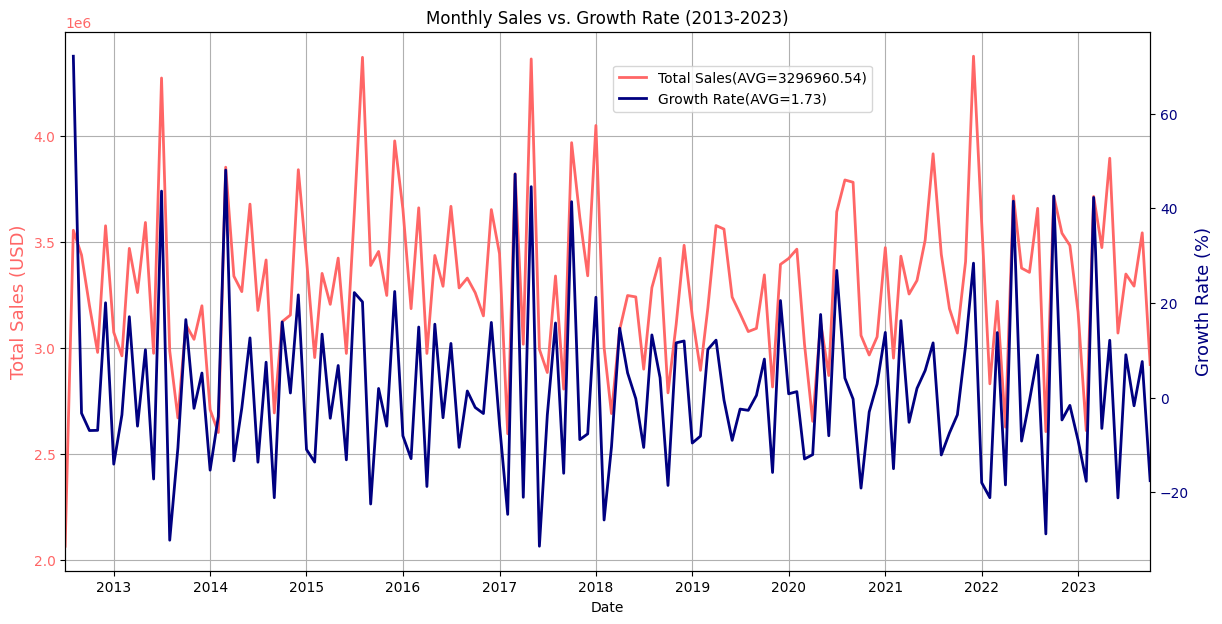

In [ ]:
import matplotlib.dates as mdates

color_growth = 'navy'
color_sales = '#ff6666'

fig, ax1 = plt.subplots(figsize=(14,7))
ax2 = ax1.twinx()

# before we plot the reuslts lets convert the 'date' to datetime objects
results6['date'] = pd.to_datetime(results6['date'],format='%Y-%m')

ax1.plot(results6['date'], results6['total_sales'], color= color_sales, lw=2, label=f'Total Sales(AVG={np.mean(results6["total_sales"]):.2f})')
ax2.plot(results6['date'], results6['growth_rate'], color= color_growth,lw=2, label = f'Growth Rate(AVG={np.mean(results6["growth_rate"]):.2f})')

ax1.set_xlabel('Date')
ax1.set_ylabel('Total Sales (USD)', color=color_sales, fontsize=13)
ax1.tick_params(axis='y', labelcolor=color_sales)
ax2.set_ylabel('Growth Rate (%)', color=color_growth, fontsize=13)
ax2.tick_params(axis='y', labelcolor=color_growth)

# set major ticks to only show years
ax1.xaxis.set_major_locator(mdates.YearLocator())
# format the labels to only display years
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

# Set x-axis limits explicitly
ax1.set_xlim([results6['date'].min(), results6['date'].max()])

ax1.set_title('Monthly Sales vs. Growth Rate (2013-2023)')
ax1.legend(handles=ax1.lines+ax2.lines, loc='best',bbox_to_anchor=(0.75, 0.95), bbox_transform=ax1.transAxes)
ax1.grid(True)
plt.show()

Looking at the detailed plot above we can see that the total sales and growth rate are relatively proportionate to each other. This what we expect over a 10 year period. The average sales over a decade is ~3.3mn USD while the growth rate hovers around ~1.73% which is good but not great. It means that growth was either slow or stagnant so the company needs to promote products aggresively or make better products or both.

In [ ]:
# high value vs low value customers
q7 = ''' WITH high_value_customers AS (
  SELECT o.CustomerID, o.OrderID, SUM(od.Quantity*od.UnitPrice*(1-od.Discount)) AS total_sales
  FROM Orders o
  JOIN `Order Details` od ON o.OrderID=od.OrderID
  GROUP BY o.CustomerID, o.OrderID
  ),
  customer_categories AS (
  SELECT CustomerID, OrderID, total_sales,
  CASE
    WHEN total_sales > AVG(total_sales) OVER () THEN 'High Value'
    ELSE 'Low Value'
  END AS customer_category
  FROM high_value_customers
  )
  SELECT CustomerID, OrderID, total_sales, customer_category, COUNT(*) OVER (PARTITION BY customer_category) AS customer_count
  FROM customer_categories;
'''
results7 = pd.read_sql(q7, conn)
results7


,CustomerID,OrderID,total_sales,customer_category,customer_count
0,REGGC,11080,29795.06,High Value,7994
1,PERIC,11081,53626.39,High Value,7994
2,PARIS,11083,43092.54,High Value,7994
3,BLONP,11084,52279.88,High Value,7994
4,PRINI,11088,40621.17,High Value,7994
...,...,...,...,...,...
16277,MEREP,26520,22377.09,Low Value,8288
16278,MAISD,26521,17931.55,Low Value,8288
16279,FOLIG,26524,4379.35,Low Value,8288
16280,WHITC,26525,3572.05,Low Value,8288


In [ ]:
# top performing categories
q8 = ''' WITH product_sales AS (
  SELECT od.ProductID, SUM(od.Quantity*od.UnitPrice*(1-od.Discount)) AS total_sales, pr.ProductName, pr.CategoryID, c.CategoryName
  FROM `Order Details` od
  JOIN Products pr ON od.ProductID=pr.ProductID
  JOIN Categories c ON pr.CategoryID=c.CategoryID
  GROUP BY c.CategoryID
  ),
  product_sales_percentage AS (
  SELECT CategoryID, CategoryName, ROUND(total_sales/(SUM(total_sales) OVER ())*100,2) AS sales_percentage
  FROM product_sales
  ORDER BY sales_percentage DESC
  )
  SELECT *
  FROM product_sales_percentage;
'''
results8 = pd.read_sql(q8, conn)
results8

,CategoryID,CategoryName,sales_percentage
0,1,Beverages,20.55
1,3,Confections,14.79
2,6,Meat/Poultry,14.47
3,4,Dairy Products,12.94
4,2,Condiments,12.44
5,8,Seafood,11.13
6,7,Produce,7.29
7,5,Grains/Cereals,6.37


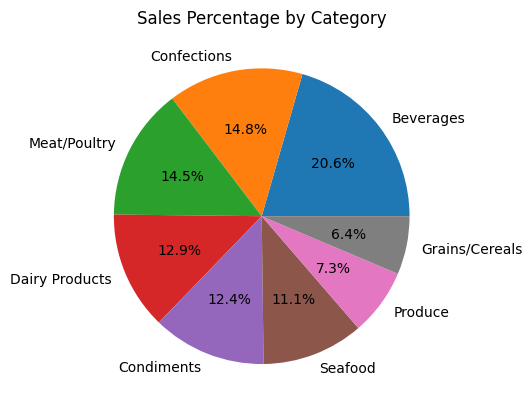

In [ ]:
plt.pie(results8['sales_percentage'], labels=results8['CategoryName'], autopct='%1.1f%%')
plt.title('Sales Percentage by Category')
plt.show()

Looking the results of the pie chart we can see that 1/5th of the top category of sales is by the Beverages section. While Meat/Poultry and Confections take 2nd and 3rd respectively, coming in at around 14% each. In the next section we take this analysis further to look at the top 3 products from each category.

In [ ]:
# top products in each category
q9 = ''' WITH total_product_sales AS (
  SELECT SUM(od.Quantity*od.UnitPrice*(1-od.Discount)) AS total_sales, p.ProductName, p.ProductID, p.CategoryID, c.CategoryName
  FROM `Order Details` od
  JOIN Products p ON od.ProductID=p.ProductID
  JOIN Categories c ON p.CategoryID=c.CategoryID
  GROUP BY p.ProductID,p.CategoryID
  )
  SELECT ProductName, ProductID, CategoryID, total_sales, CategoryName
  FROM ( SELECT ProductName, ProductID, CategoryID, total_sales, CategoryName, ROW_NUMBER() OVER(PARTITION BY CategoryID ORDER BY total_sales DESC) AS row_number
          FROM total_product_sales)
  WHERE row_number <= 3;
'''
results9 = pd.read_sql(q9, conn)
results9


,ProductName,ProductID,CategoryID,total_sales,CategoryName
0,Côte de Blaye,38,1,5.326590e+07,Beverages
1,Ipoh Coffee,43,1,9.333375e+06,Beverages
2,Chang,2,1,3.830511e+06,Beverages
3,Vegie-spread,63,2,8.810705e+06,Condiments
4,Northwoods Cranberry Sauce,8,2,8.073652e+06,Condiments
5,Sirop d'érable,61,2,5.839810e+06,Condiments
6,Sir Rodney's Marmalade,20,3,1.665381e+07,Confections
7,Tarte au sucre,62,3,9.952936e+06,Confections
8,Schoggi Schokolade,27,3,8.829078e+06,Confections
9,Raclette Courdavault,59,4,1.121641e+07,Dairy Products


In [ ]:
conn.close()

# Conclusion

After a detailed analysis of the Northwind traders database we can come up with a couple of conclusions :
*   Margaret Peacock, Steven Buchanan, and Janet Leverling where the best performing employees, so they should be next leaders to help new or naive employees.
*   Sales and growth rate has be pretty stagnant over a 10 year period. While the growth is positive, it is stil not high. We need a more agressive approach in order to see a stronger growth and higher total sales
*   There are slightly more low value customers than high value ones, so we should see how we can make more high value customers with ratio at least 3:2 high value clients.
*   Finally the least performing categories in terms of sales were Grains/Cereal, Produce and Seafood. We have to come up with better products in these categoies and better promotion of these products for a more equal share of sales.

This concludes the analysis.